# 1. 计算图在深度学习框架中的应用

## 1.1 Computational Graphs

### 构建计算图

计算图是应用图理论表示数学公式的一种方法。
这个图是由节点和边组成的。

在计算图中，节点可以式输入值，也可以是一些函数。
边表示这个数据在图中流向的权重值。

拿下面函数为例
e=(a+b)∗(b+1) 

将上述公式的拆成最基本的子运算
c=a+b
d=b+1
e=c∗d

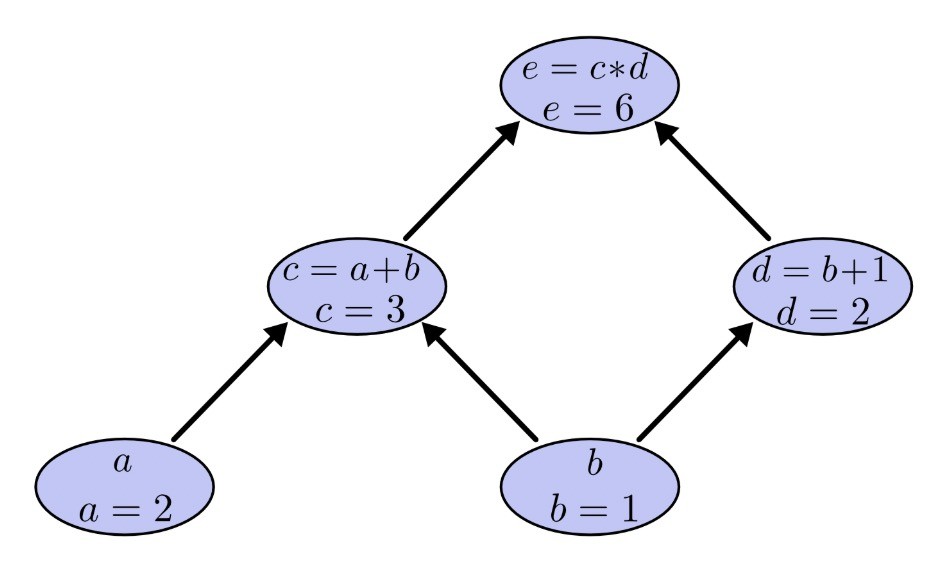

### Derivatives on Computational Graphs


一般的规则是对从一个节点到另一个节点的所有可能路径求和，将路径每条边上的导数相乘。例如

∂e/∂b=1∗2+1∗3

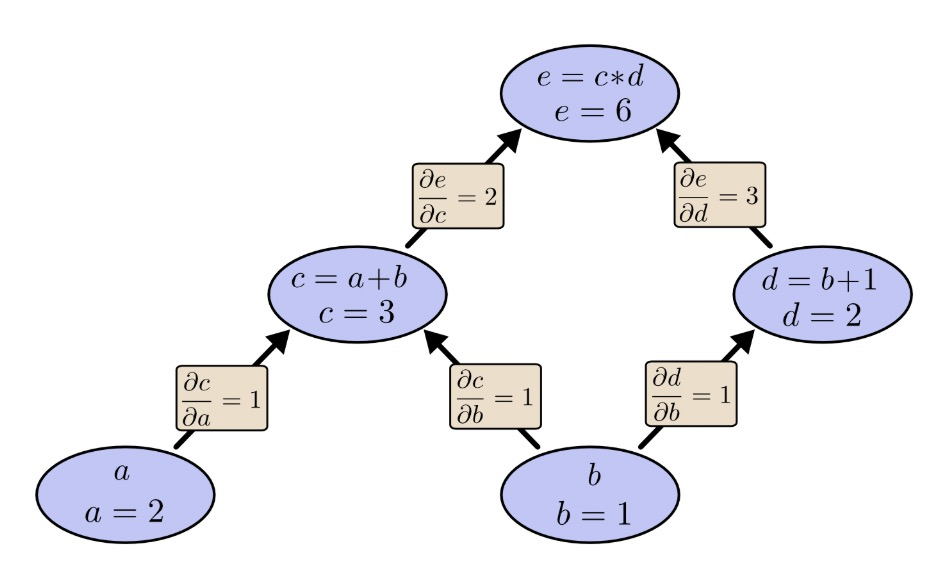

### Factoring Paths 因式分解路径

在下图中，从X到Y有3条路径，从Y到Z同样有3条路径。
如果我们想得到∂Z/∂X，需要通过下面的公式计算：
∂Z/∂X=αδ+αϵ+αζ+βδ+βϵ+βζ+γδ+γϵ+γζ
总共通过了3* 3=9条路径


随着公式变得越来越复杂，路径就会很复杂，但是如果采用图的方式就可以很好的解决这个问题，我们可以将路径整理下，得到：

∂Z/∂X=(α+β+γ)(δ+ϵ+ζ)



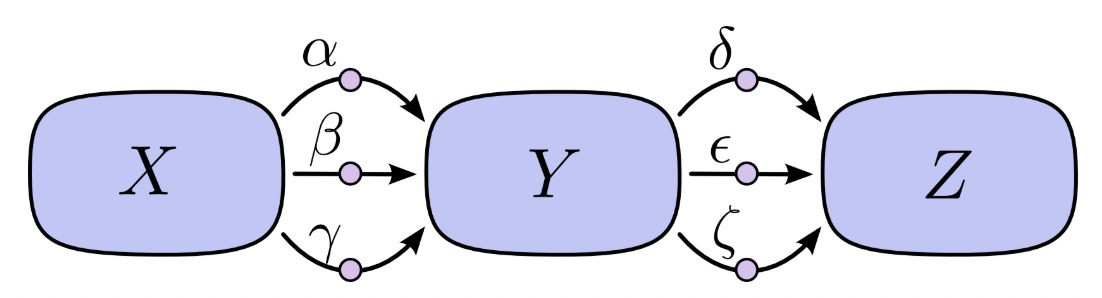

### Forward-mode differentiation

前向模式微分，是从图的输入开始，一直推到末端。每个路径代表一种方法，将所有通过路径的结果想加。


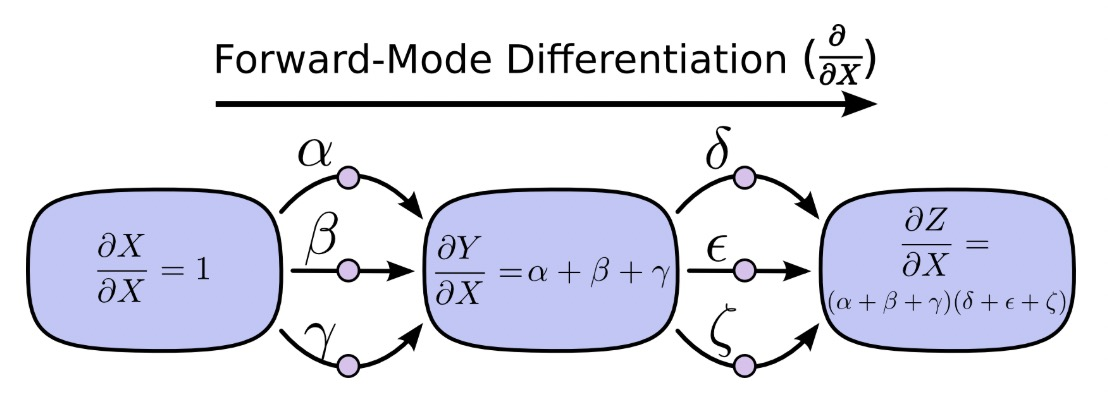

### Reverse-mode differentiation

反向模式微分，求导的方式是从图的输出端反向递推到输入端，然后融合所有路径的结果。

Forward-mode differentiation是一个输入影响每个节点，Reverse-mode differentiation恰恰相反，是每个节点影响整个输出。
Forward-mode differentiation在每个节点上都是对∂/∂X求导，Reverse-mode differentiation是在每个节点上∂Z/∂。


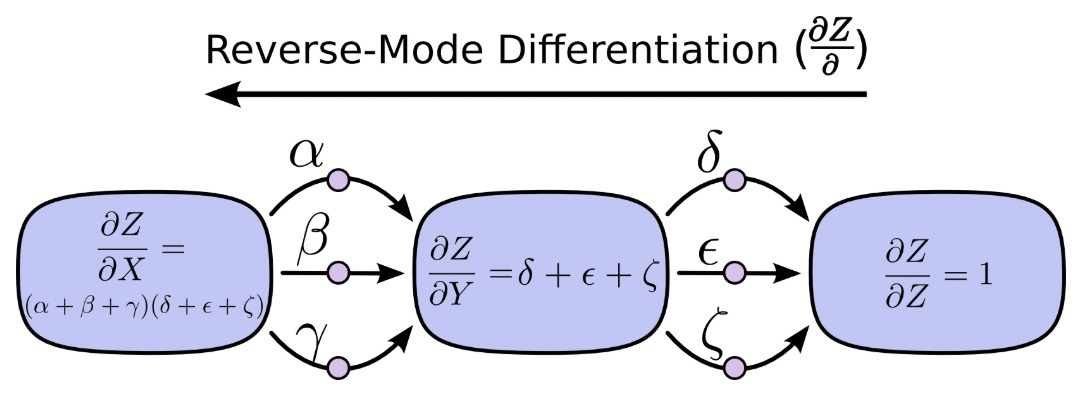

如果我们采用forward-mode differentiation，从输入b对每个节点求导。
最终计算∂e/∂b


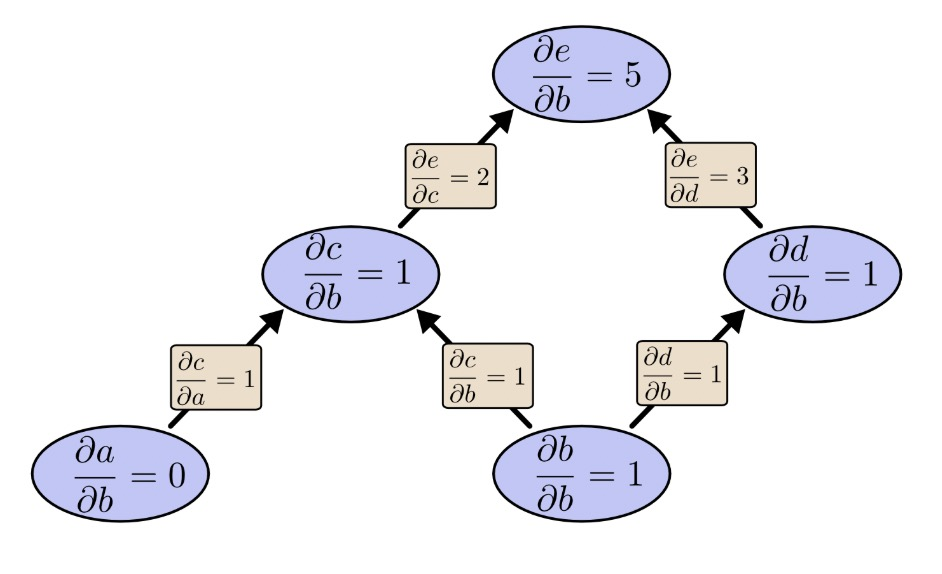

当采用reverse-mode differentiation时，如下图，对每个节点进行操作后，同时得到∂e/∂a和∂e/∂b。



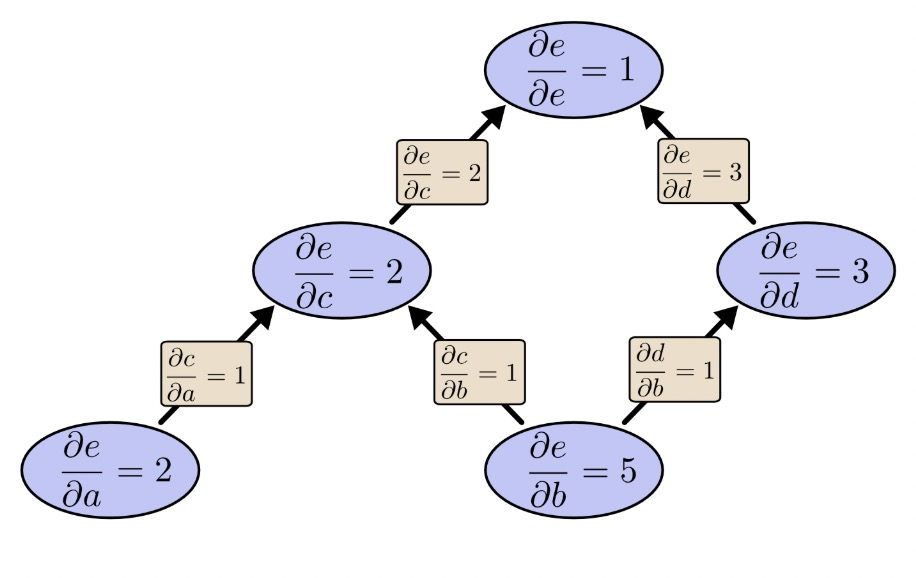

从上面这些图中可以看出

对于这个图，这只是两个输入，如果有一百万个输入时，Forward-mode differentiation需要我们对图进行一百万次的遍历才能得到导数。Reverse-mode differentiation可以一蹴而就！百万分之一的速度就可以解决问题。


## 1.2 Dynamic vs Static computation graph

静态图计算分为两步：

第一步，定义图的结构，例如输入、多少层网络、loss定义、结果预测

第二步，执行图的计算，通过不断的计算，利用反向传播来计算loss

优点：

因为静态图是只用定义一次图结构，所以在训练和测试速度上会更快一些；

缺点：

如果输入的尺寸并不是固定的，就很难定义；

输入输出的结构包括文本、图像等多种格式；

因为静态图的这些特性，给debug带来很大的困难

动态图兼容python的各种逻辑控制语法，每次都会重新构建一个新的计算图

我们在选择框架时优先考虑程序员编程的便捷性（能更方便地进行调试和更直观地设计），而不是框架所能带来的模型加速能力

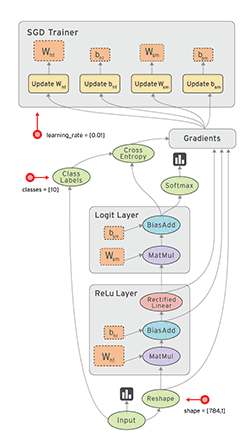

## 1.3 Automatic differentiation and gradient tape in tensorflow


TensorFlow provides the tf.GradientTape API for automatic differentiation - computing the gradient of a computation with respect to its input variables. 

Tensorflow "records" all operations executed inside the context of a tf.GradientTape onto a "tape". Tensorflow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [1]:
import tensorflow as tf

In [2]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
    t.watch(x)
    print(x)
    print(t)
    
    y = tf.reduce_sum(x)
    print(y)
    z = tf.multiply(y, y)
    print(z)
    
    dz_dx = t.gradient(z, x)
    print(dz_dx)
    for i in [0, 1]:
        for j in [0, 1]:
            assert dz_dx[i][j].numpy() == 8.0

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


Higher-order gradients

In [4]:
x = tf.Variable(1.0)

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        y = x * x * x
    dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 5

AssertionError: 

TF 2.0 brings together the ease of eager execution and the power of TF 1.0. At the center of this merger is tf.function, which allows you to transform a subset of Python syntax into portable, high-performance TensorFlow graphs.
A cool new feature of tf.function is AutoGraph, which lets you write graph code using natural Python syntax. 

In [5]:
@tf.function
def simple_nn_layer(x, y):
    return tf.nn.relu(tf.matmul(x, y))

x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

simple_nn_layer(x, y)

<tf.Tensor: id=135, shape=(3, 3), dtype=float32, numpy=
array([[0.21458118, 0.40098485, 0.36841437],
       [0.5863481 , 1.1464046 , 0.94372475],
       [0.5484118 , 1.1886907 , 0.85499007]], dtype=float32)>

In [6]:
simple_nn_layer

An in-graph training loop

In [7]:
# Download data
def prepare_mnist_features_and_labels(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

def mnist_dataset():
    (x, y), _ = tf.keras.datasets.mnist.load_data()
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    return ds

train_dataset = mnist_dataset()

In [14]:
# Define the model
model = tf.keras.Sequential((tf.keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(10)))
model.build()
# optimizer = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()

In [15]:
# Define the training loop
compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [16]:
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as t:
        logits = model(x)
        loss = compute_loss(y, logits)
    grads = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
#     compute_loss(y, logits)
    compute_accuracy(y, logits)
    return loss

@tf.function
def train(model, optimizer):
    train_ds = mnist_dataset()
    step = 0
    loss = 0.0
    accuracy = 0.0
    for x, y in train_ds:
        step += 1
        loss = train_one_step(model, optimizer, x, y)
        if step % 10 == 0:
            tf.print('Step', step, 'loss', loss, 'accuracy', compute_accuracy.result())
    return step, loss, accuracy

step, loss, accuracy = train(model, optimizer)
print('Final step', step, ': loss', loss, '; accuracy', compute_accuracy.result())

Step 10 loss 1.88561893 accuracy 0.344
Step 20 loss 1.19120014 accuracy 0.5255
Step 30 loss 0.710625708 accuracy 0.609666646
Step 40 loss 0.49134925 accuracy 0.668
Step 50 loss 0.589290679 accuracy 0.703
Step 60 loss 0.560512185 accuracy 0.72966665
Step 70 loss 0.473007977 accuracy 0.749285698
Step 80 loss 0.374834061 accuracy 0.768
Step 90 loss 0.252177835 accuracy 0.782333314
Step 100 loss 0.354902834 accuracy 0.7933
Step 110 loss 0.304206133 accuracy 0.802454531
Step 120 loss 0.346638292 accuracy 0.81125
Step 130 loss 0.30825448 accuracy 0.817923069
Step 140 loss 0.207617223 accuracy 0.824785709
Step 150 loss 0.31469059 accuracy 0.829666674
Step 160 loss 0.213366911 accuracy 0.83475
Step 170 loss 0.279972643 accuracy 0.839882374
Step 180 loss 0.276125312 accuracy 0.84466666
Step 190 loss 0.2641491 accuracy 0.848842084
Step 200 loss 0.195584178 accuracy 0.85235
Final step tf.Tensor(200, shape=(), dtype=int32) : loss tf.Tensor(0.19558418, shape=(), dtype=float32) ; accuracy tf.Tensor(

In [ ]:
def train(src_vocab_size='', target_vocab_size='', embedding_dim='', hidden_dim='', batch_sz='',
          learning_rate='', log_dir='', train_path='', dataset_size='', epochs='',
          steps_per_epoch='', checkpoint_path=''):
    encoder = Encoder(vocab_size=src_vocab_size,
                      embedding_dim=embedding_dim,
                      enc_units=hidden_dim,
                      batch_sz=batch_sz)

    decoder = Decoder(vocab_size=target_vocab_size,
                      embedding_dim=embedding_dim,
                      dec_units=hidden_dim,
                      batch_sz=batch_sz)

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                        reduction=tf.keras.losses.Reduction.NONE)

    def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = cce(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)

    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

    # log
    file_writer = tf.summary.create_file_writer(logdir=log_dir)

    # data set API
    input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path=train_path,
                                                                    num_examples=None)
    print(inp_lang.word_index)
    print(len(inp_lang.word_index))
    print(len(targ_lang.word_index))
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(dataset_size)
    dataset = dataset.batch(batch_sz, drop_remainder=True)

    def train_step(inp, targ, init_enc_hidden):
        loss = 0.0
        with tf.GradientTape() as tape:
            # encoder
            enc_output, enc_hidden = encoder(inp, init_enc_hidden)

            # decoder
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * batch_sz, 1)
            # print("dec_input:\n",dec_input)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                # print("predictions:\n", predictions)

                loss += loss_function(targ[:, t], predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss


    for epoch in range(epochs):
        total_loss = 0
        init_enc_hidden = encoder.initialize_hidden_state()

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, init_enc_hidden)
            total_loss += batch_loss
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
            # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_path)
        print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

# 2. attention和beam search

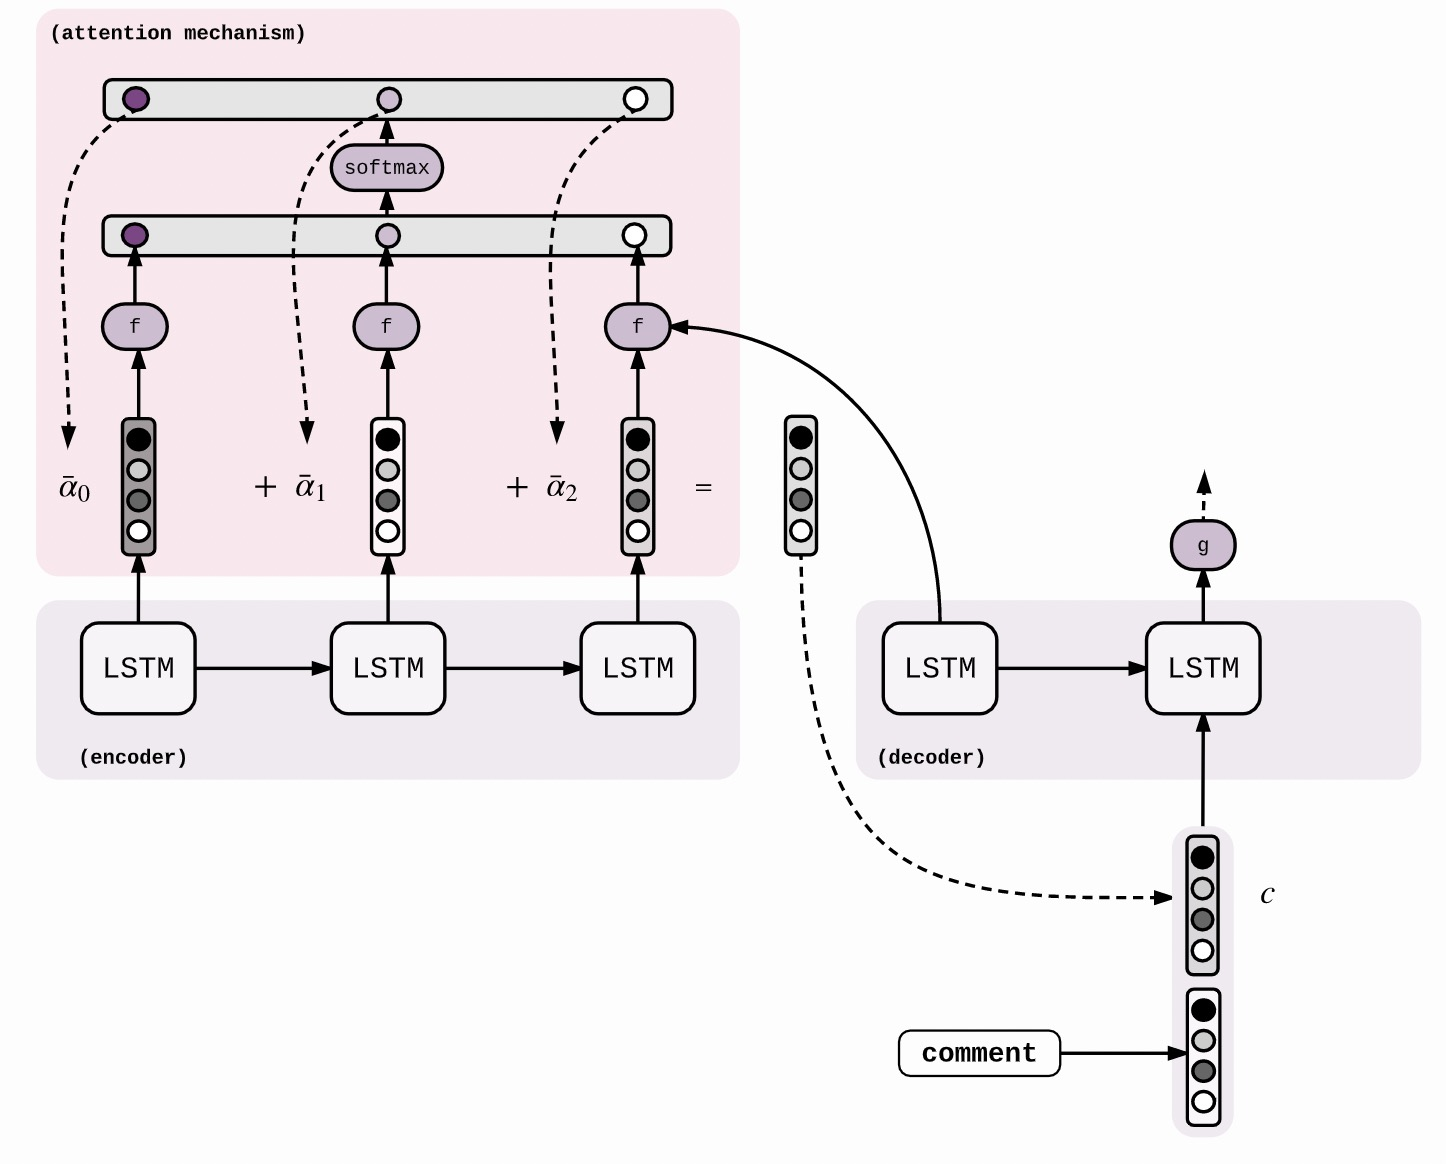
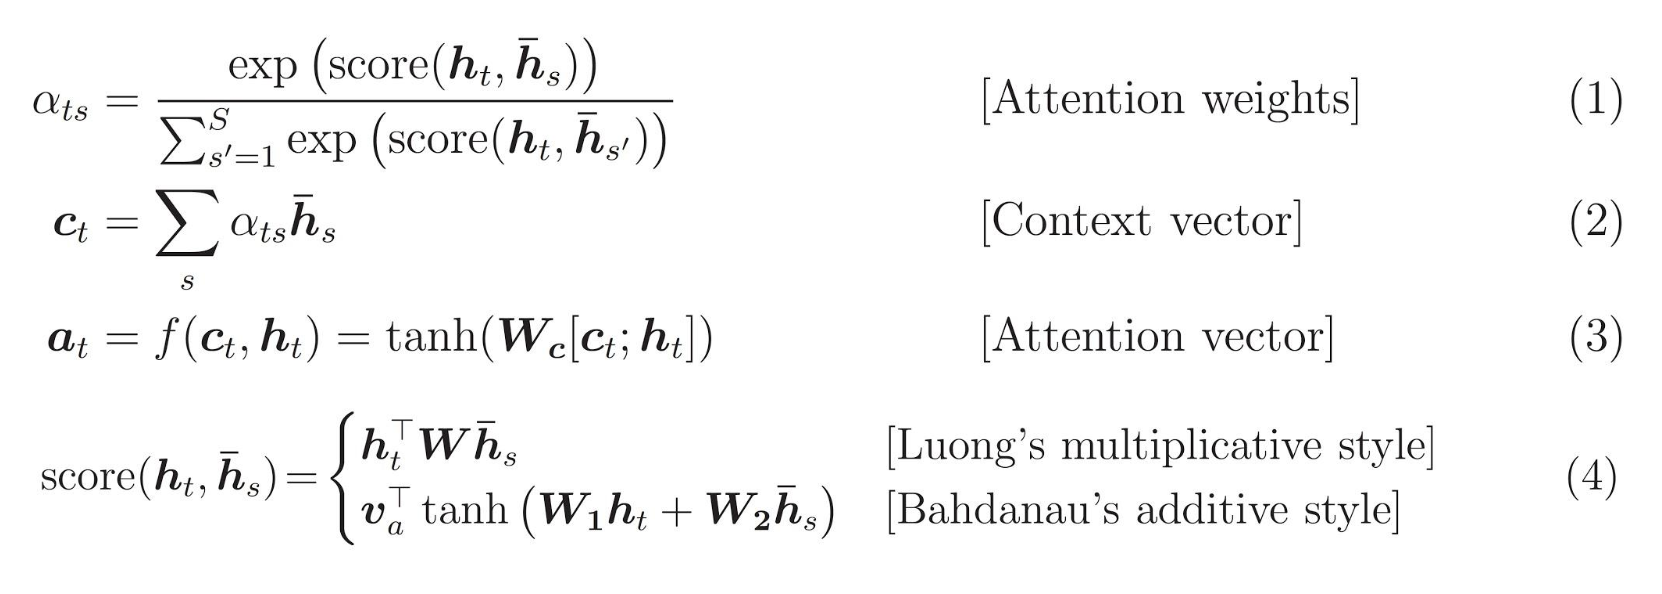

看下pycharm代码，debug

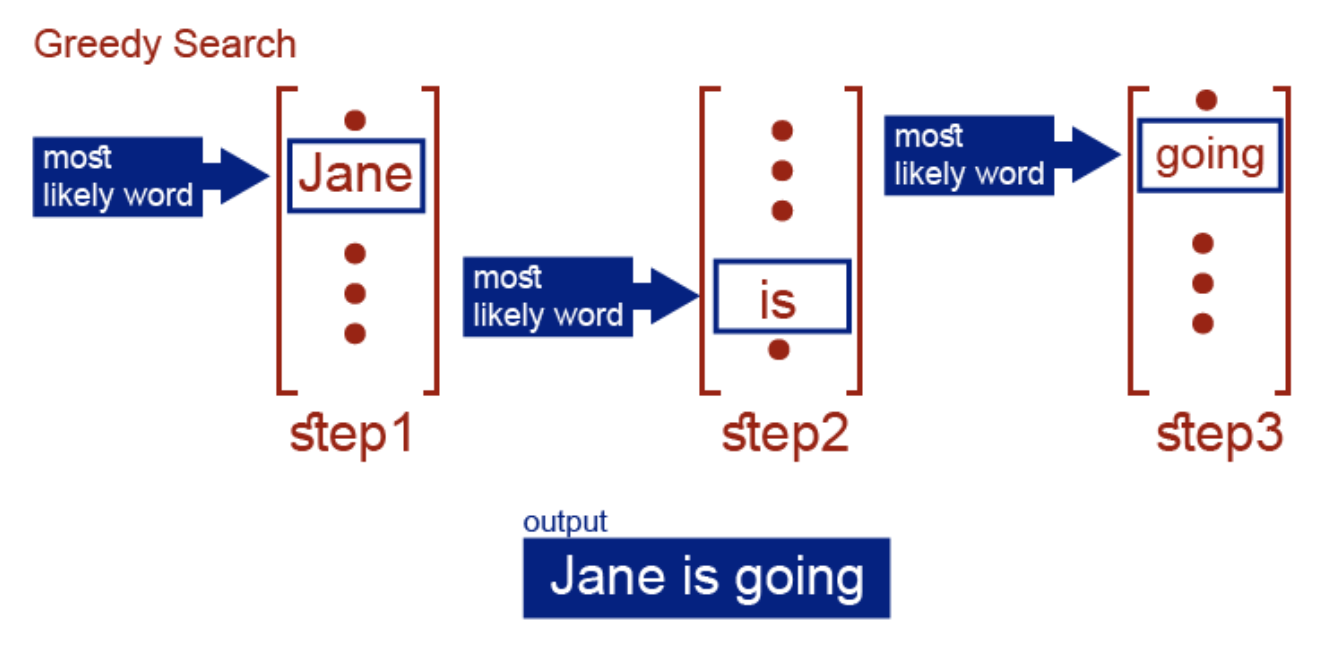

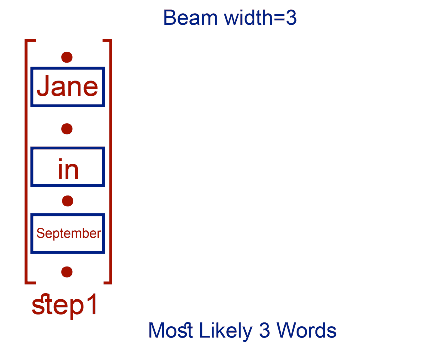

In [ ]:
import numpy as np

def beam_search(model, src_input, k=3, sequence_max_len=25):
    k_beam = [(0, [0]*(sequence_max_len+1))]
    
    for l in range(sequence_max_len):
        all_k_beam = []
        for prob, sent_predict in k_beam:
            predicted = model.predict([np.array([src_input]), np.array([sent_predict])])[0]
            
            prossible_k = predicted[1].argsort()[-k:][::-1]
            
            all_k_beams += [
                (
                sum(np.log(predicted[i][sent_predict[i+1]]) for i in range(1)) + np.log(predicted[1][next_wid]),
                list(sent_predict[:l+1])+[next_wid]+[0]*sequence_max_len-1-1)
                )
#                 for next_wid in prossible_k
            ]
            
        k_beam = sorted(all_k_beams)[-k:]
    return k_beam

# 3 Initializing neural networks

## 高效初始化的重要性
由于神经网络的对称性决定
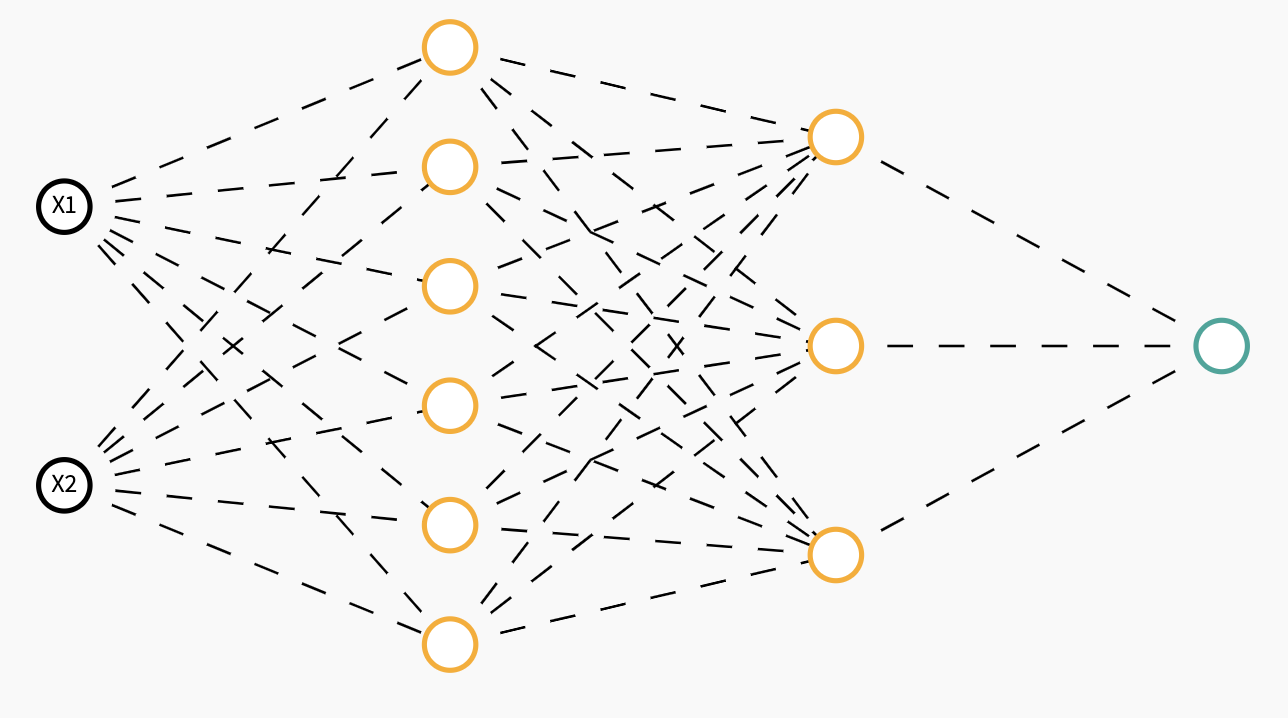

## 梯度消失和爆炸
太大和太小随着网络深度的增加会带来问题
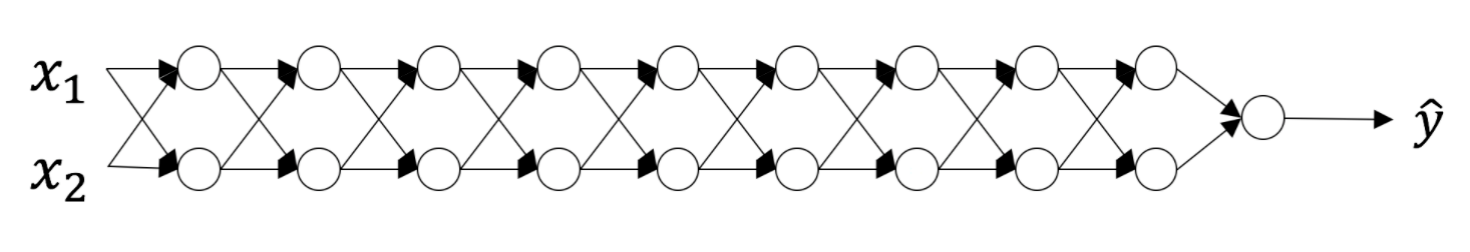

## 如何找到恰当的初始值
满足以下两种情况的参数初始值比较好：
1. 神经元输出值的均值为0
2. 每一层神经元输出值的方差


\begin{aligned}a^{[l-1]} &= g^{[l-1]}(z^{[l-1]})\\ z^{[l]} &= W^{[l]}a^{[l-1]} + b^{[l]}\\ a^{[l]} &= g^{[l]}(z^{[l]})\end{aligned} 


\begin{aligned}E[a^{[l-1]}] &= E[a^{[l]}]\\ Var(a^{[l-1]}) &= Var(a^{[l]})\end{aligned} 


该方法确保平均值为零，并保持每一层输入的方差值，避免梯度消失和爆炸现象，此方法同时适用于正向传播和反向传播。对于神经网络的每一层，建议使用xavier初始化（或其派生方法之一）

glorot_normal_initializer.

\begin{aligned}W^{[l]} &\sim \mathcal{N}(\mu=0,\sigma^2 = \frac{1}{n^{[l-1]}})\\ b^{[l]} &= 0\end{aligned} 

# 4 Parameter optimization in neural networks

## 4.1 loss function
根据不同问题定义不同的loss function
例如预测问题-平方损失
例如物体检测问题

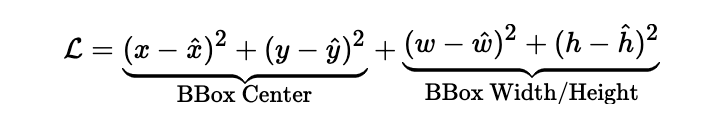

## 4.2 Cost function

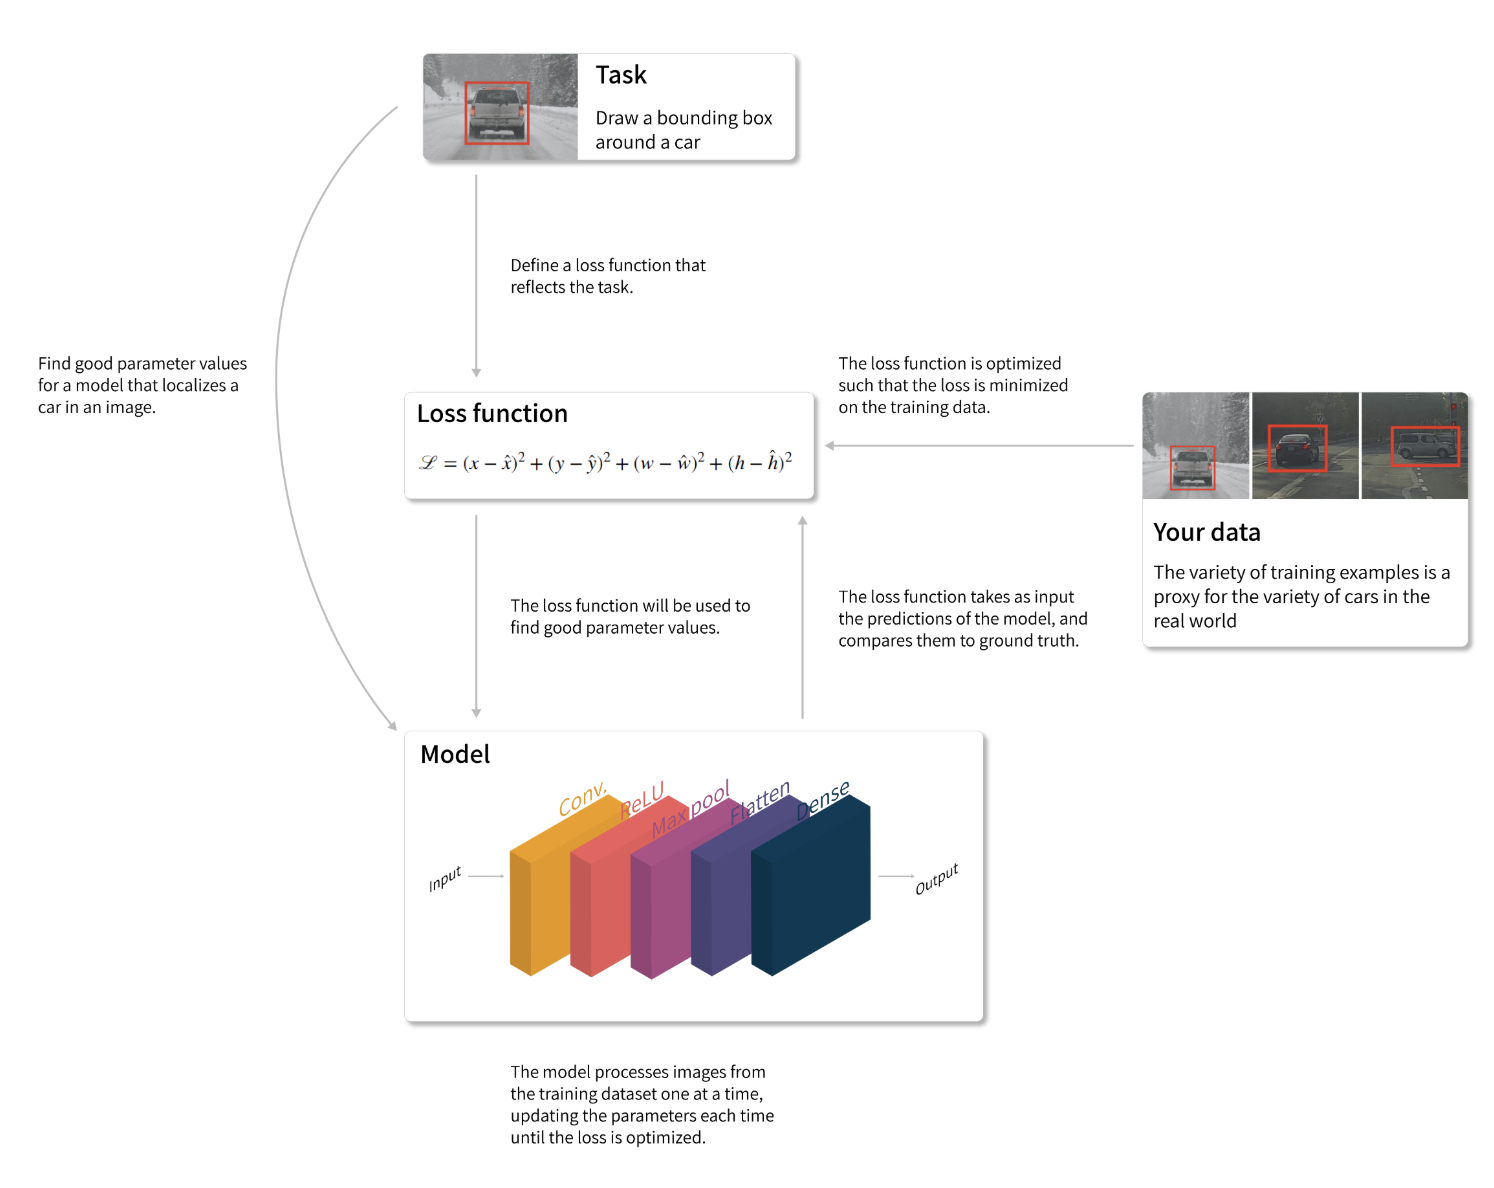

Tips：

1. 即使选择了最佳的超参数，训练后的模型也不会完全匹配真实的标签结果，因为数据集才是决定模型好坏的最根本。

2. 训练集的越大，训练的模型参数就越接近用于生成数据的参数。

3. 如果你的学习率太大，你的算法就不会收敛。如果它太小，你的算法收敛速度会很慢。


## 4.3 Batch size

1. Batch size是用于在每次迭代中训练模型的数据数量。一般的设置是32, 64, 128，256, 512。

2. 选择正确的Batch size对于确保cost function和参数值的收敛，以及模型的泛化能力。

3. Batch size决定更新的频率。Batch size越小，更新就越快。

4. Batch size越大，梯度越精确。也就是说，在迭代计算的时候更容易跳过局部区域。

5. 比较大Batch size，往往GPU memory是不够用的，就需要通过并行计算的方式解决。

## 4.4 Choice of optimizer


### 4.4.1 (Stochastic) Gradient Descent

W=W−αdW

1. 梯度下降可以有效地使用并行化，但是当GPU的存储器处理数据集较大时非常慢。并行化不是最优的。

2. 在大数据集上，随机梯度下降通常比梯度下降收敛更快，因为更新更频繁。另外，梯度的随机逼近通常是精确的，而不使用整个数据集，因为数据通常是冗余的。

3. 在优化器中，随机梯度下降对给定的batch size时使用内存是最小的。


### 4.4.2 Momentum

\begin{aligned} V_{dW} &= \beta V_{dW} + ( 1 - \beta ) dW\\ W &= W - \alpha V_{dW} \end{aligned} 

1. 动量通过对梯度的学习，实现一个加速的效果。

2. 动量比随机梯度下降使用更多的内存，但比rmsprop和adam要少。





### 4.4.3 RMSprop	

\begin{aligned} S_{dW} &= \beta S_{dW} + ( 1 - \beta ) dW^2\\ W &= W - \alpha \frac{dW}{\sqrt{S_{dW}} + \varepsilon} \end{aligned} 


1. rmsprop的自适应学习速率通常可以防止学习速率衰减过慢或过快。

2. 与随机梯度下降和动量相比，rmsprop在给定batch size下使用的内存更多，但比adam少。






### 4.4.4 Adam

\begin{aligned} V_{dW} &= \beta_1 V_{dW} + ( 1 - \beta_1 ) dW\\ S_{dW} &= \beta_2 S_{dW} + ( 1 - \beta_2 ) dW^2\\ Vcorr_{dW} &= \frac{V_{dW}}{(1 - \beta_1)^t}\\ Scorr_{dW} &= \frac{S_{dW}}{(1 - \beta_2)^t}\\ W &= W - \alpha \frac{dW}{\sqrt{S_{dW}} + \varepsilon} \end{aligned} 


1. Adam的超参数（学习速率，指数衰减率等）通常被设置为预定义值，并且不需要调。
2. Adam采用自适应步长进行学习率的变化。
3. 在优化器中，Adam在给定的batch size中使用的内存最多。
4. Adam一般在机器学习当中都是默认首选的优化器。




